# 맵 생성 및 검증 단계별 분석

## 라이브러리 및 설정

In [33]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import logging

from src.map_generator import MapGenerator
from src.spatial_analyzer import create_full_analysis, VisibilityAnalyzer
from src.validation_engine import ValidationEngine, create_default_rules
from src.logger import LoggerConfig

# Jupyter notebook에서 그래프를 inline으로 표시
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

LoggerConfig.setup_logging(
    log_dir='../logs',
    log_level=logging.WARNING,
    console_output=False,
    file_output=True
)

# 시각화시 한글 폰트 사용
plt.rcParams['font.family'] = 'NanumSquare'
plt.rcParams['font.monospace'] = 'NanumSquare'
plt.rcParams['axes.unicode_minus'] = False

## 파라미터 설정

맵 생성/분석에 사용할 파라미터 설정

**중요**: 전수 조사는 계산량이 많으므로 작은 맵(64x64 또는 128x128)을 권장
- 64x64: ~2.5분
- 128x128: ~1-2시간  
- 256x256: ~23시간 (비권장)

In [34]:
# 맵 생성 파라미터
MAP_WIDTH = 64           # 맵 너비 (64x64 권장, 전수 조사에 적합)
MAP_HEIGHT = 64          # 맵 높이 (단위: px)
OCTAVES = 6              # Perlin noise 옥타브 (높을수록 디테일 증가)
PERSISTENCE = 0.5        # 작은 디테일 강도
LACUNARITY = 2.0         # 주파수 배율
SCALE = 100.0            # 전체 스케일 (작을수록 빠른 변화)
SEED = 4                 # 랜덤 시드 (같은 시드 = 같은 맵)

# 분석 파라미터
OBSERVER_HEIGHT = 0.05   # 관측자 높이 (캐릭터 크기로 설정)
USE_FULL_ANALYSIS = True # True = 전수 조사 (모든 픽셀), False = 샘플링
NUM_SAMPLES = 50         # 샘플링 모드용 샘플 수 (전수 조사 시 무시됨)
EPSILON = 0.001          # 높이 비교 허용 오차

print("=" * 60)
print("파라미터 설정")
print("=" * 60)
print(f"맵 크기: {MAP_WIDTH}x{MAP_HEIGHT}")
print(f"Perlin noise: octaves={OCTAVES}, persistence={PERSISTENCE}")
print(f"분석 모드: {'FULL (전수 조사)' if USE_FULL_ANALYSIS else 'SAMPLING'}")
print(f"관측자 높이: {OBSERVER_HEIGHT}")
print(f"시드: {SEED}")
print("=" * 60)

if MAP_WIDTH > 128 and USE_FULL_ANALYSIS:
    print("경고: 큰 맵에서 전수 조사는 매우 오래 걸립니다!")

파라미터 설정
맵 크기: 64x64
Perlin noise: octaves=6, persistence=0.5
분석 모드: FULL (전수 조사)
관측자 높이: 0.05
시드: 4


# 1. 원본 Heightmap 생성


**Perlin noise 알고리즘**을 사용, 자연스러운 지형 생성


INFO     | Initialized MapGenerator: 64x64, octaves=6, seed=4
INFO     | Starting map generation...
INFO     | Map generation complete: 64x64, 2 zones


맵 생성 중
맵 생성 완료


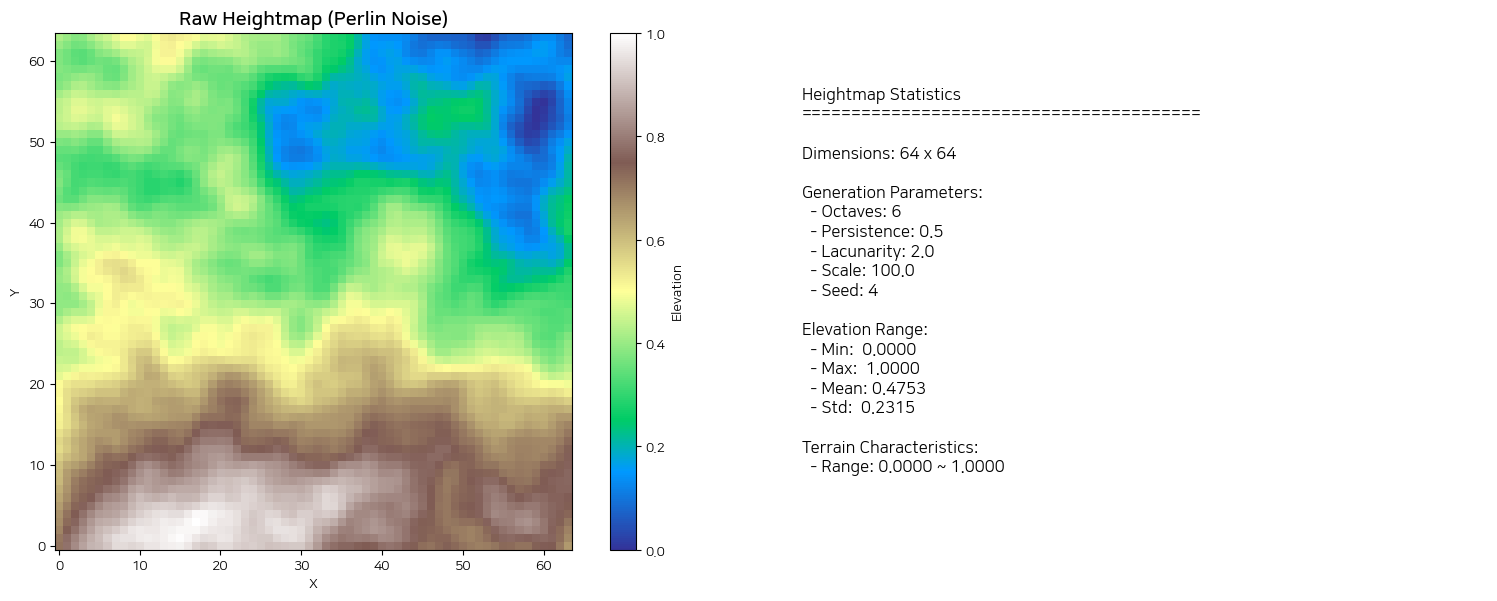

In [35]:
# 맵 생성기 초기화
generator = MapGenerator(
    width=MAP_WIDTH,
    height=MAP_HEIGHT,
    octaves=OCTAVES,
    persistence=PERSISTENCE,
    lacunarity=LACUNARITY,
    scale=SCALE,
    seed=SEED
)

# 맵 생성
print("맵 생성 중")
map_data = generator.generate_map()
# tqdm 등으로 진행률 계산하면 좋을 것 같음
print("맵 생성 완료")

# 통계 계산
heightmap = map_data.heightmap
stats = {
    'min': heightmap.min(),
    'max': heightmap.max(),
    'mean': heightmap.mean(),
    'std': heightmap.std()
}

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heightmap
im = ax1.imshow(heightmap, cmap='terrain', origin='lower')
ax1.set_title('Raw Heightmap (Perlin Noise)', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
plt.colorbar(im, ax=ax1, label='Elevation')

# Heightmap Statistics
ax2.axis('off')
stats_text = f"""
Heightmap Statistics
{'='*40}

Dimensions: {MAP_WIDTH} x {MAP_HEIGHT}

Generation Parameters:
  - Octaves: {OCTAVES}
  - Persistence: {PERSISTENCE}
  - Lacunarity: {LACUNARITY}
  - Scale: {SCALE}
  - Seed: {SEED}

Elevation Range:
  - Min:  {stats['min']:.4f}
  - Max:  {stats['max']:.4f}
  - Mean: {stats['mean']:.4f}
  - Std:  {stats['std']:.4f}

Terrain Characteristics:
  - Range: {stats['min']:.4f} ~ {stats['max']:.4f}

"""
ax2.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.show()

---

# 2. 팀 존 할당

맵을 Team A (파란색)과 Team B (빨간색) 구역으로 분할

- **Team Zone**: 각 팀의 스폰 지역 및 초기 거점 등을 설명하기 위함
- **좌우 대칭**: 일반적으로 공정성을 위해 좌우로 분할
- **중립 지대**: 두 팀 존이 아닌 중립 지대

### 확인 사항
- 두 팀 존의 크기가 비슷한가?
- 각 존에 높은/낮은 지형이 고르게 분포하는가?

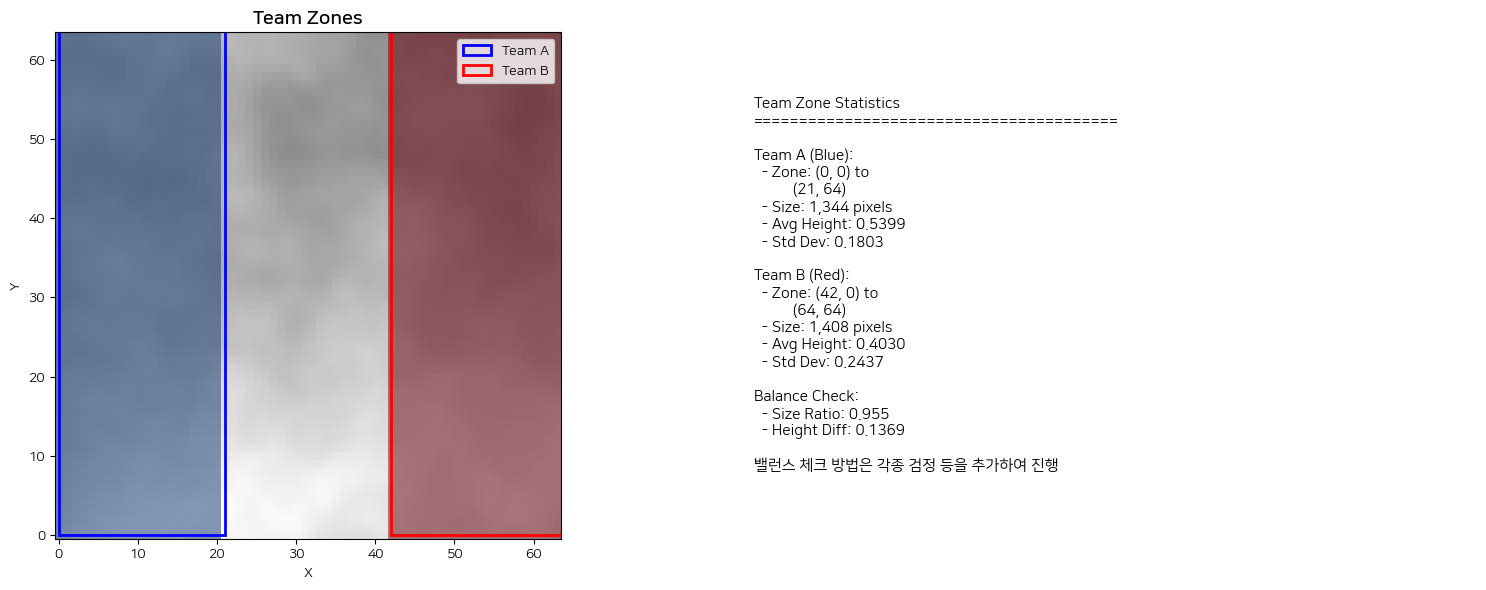

In [36]:
# 팀 존 정보 추출
zones = map_data.zones
team_a_zone = zones["team_a_zone"]
team_b_zone = zones["team_b_zone"]

# 존별 마스크 생성
mask_a = np.zeros_like(heightmap)
mask_b = np.zeros_like(heightmap)

for y in range(MAP_HEIGHT):
    for x in range(MAP_WIDTH):
        if team_a_zone.contains_point(x, y):
            mask_a[y, x] = 1
        elif team_b_zone.contains_point(x, y):
            mask_b[y, x] = 1

# 존별 통계
zone_a_heights = heightmap[mask_a == 1]
zone_b_heights = heightmap[mask_b == 1]

zone_stats = {
    'team_a': {
        'size': len(zone_a_heights),
        'mean': zone_a_heights.mean(),
        'std': zone_a_heights.std()
    },
    'team_b': {
        'size': len(zone_b_heights),
        'mean': zone_b_heights.mean(),
        'std': zone_b_heights.std()
    }
}

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 좌측: 존 오버레이
# Heightmap을 기본으로 표시
ax1.imshow(heightmap, cmap='gray', alpha=0.5, origin='lower')
# Team A 존 (파란색)
ax1.imshow(np.ma.masked_where(mask_a == 0, mask_a), 
           cmap='Blues', alpha=0.5, origin='lower', vmin=0, vmax=1)
# Team B 존 (빨간색)
ax1.imshow(np.ma.masked_where(mask_b == 0, mask_b), 
           cmap='Reds', alpha=0.5, origin='lower', vmin=0, vmax=1)

ax1.set_title('Team Zones', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# 존 경계 표시
from matplotlib.patches import Rectangle
rect_a = Rectangle((team_a_zone.bounds[0], team_a_zone.bounds[2]),
                   team_a_zone.bounds[1] - team_a_zone.bounds[0],
                   team_a_zone.bounds[3] - team_a_zone.bounds[2],
                   fill=False, edgecolor='blue', linewidth=2, label='Team A')
rect_b = Rectangle((team_b_zone.bounds[0], team_b_zone.bounds[2]),
                   team_b_zone.bounds[1] - team_b_zone.bounds[0],
                   team_b_zone.bounds[3] - team_b_zone.bounds[2],
                   fill=False, edgecolor='red', linewidth=2, label='Team B')
ax1.add_patch(rect_a)
ax1.add_patch(rect_b)
ax1.legend(loc='upper right')

# 우측: 존 통계
ax2.axis('off')
stats_text = f"""
Team Zone Statistics
{'='*40}

Team A (Blue):
  - Zone: ({team_a_zone.bounds[0]}, {team_a_zone.bounds[2]}) to 
          ({team_a_zone.bounds[1]}, {team_a_zone.bounds[3]})
  - Size: {zone_stats['team_a']['size']:,} pixels
  - Avg Height: {zone_stats['team_a']['mean']:.4f}
  - Std Dev: {zone_stats['team_a']['std']:.4f}

Team B (Red):
  - Zone: ({team_b_zone.bounds[0]}, {team_b_zone.bounds[2]}) to 
          ({team_b_zone.bounds[1]}, {team_b_zone.bounds[3]})
  - Size: {zone_stats['team_b']['size']:,} pixels
  - Avg Height: {zone_stats['team_b']['mean']:.4f}
  - Std Dev: {zone_stats['team_b']['std']:.4f}

Balance Check:
  - Size Ratio: {zone_stats['team_a']['size'] / zone_stats['team_b']['size']:.3f}
  - Height Diff: {abs(zone_stats['team_a']['mean'] - zone_stats['team_b']['mean']):.4f}

밸런스 체크 방법은 각종 검정 등을 추가하여 진행
"""
ax2.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.show()

---

# 3. 샘플 포인트 배치

가시성 분석을 위한 **대표 샘플 포인트**를 각 팀 존에 균등하게 배치

- **Observer Points (파란색)**: Team A 존의 관측 지점
- **Target Points (빨간색)**: Team B 존의 타겟 지점
- **샘플링 전략**: 모든 점을 체크할 수 없으므로 대표 샘플 사용

### 샘플 수와 정확도
- 50개: ~95% 신뢰도
- 100개: ~99% 신뢰도
- 더 많을수록 정확하지만 계산 시간 증가

✓ 50개 관측점 생성 (Team A)
✓ 50개 타겟점 생성 (Team B)


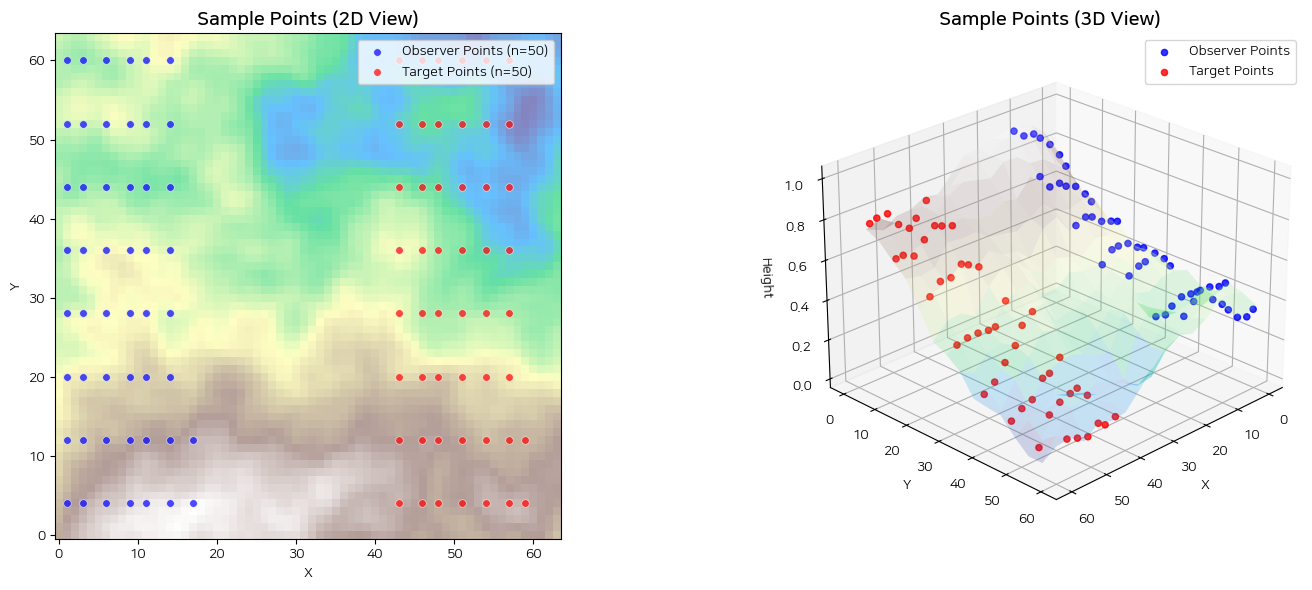

In [37]:
# 샘플 포인트 생성
def generate_sample_points(zone, heightmap, num_samples):
    """존 내에서 균등하게 샘플 포인트 생성"""
    points = []
    x_range = zone.bounds[1] - zone.bounds[0]
    y_range = zone.bounds[3] - zone.bounds[2]
    
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    x_step = x_range / grid_size
    y_step = y_range / grid_size
    
    for i in range(grid_size):
        for j in range(grid_size):
            if len(points) >= num_samples:
                break
            x = int(zone.bounds[0] + (i + 0.5) * x_step)
            y = int(zone.bounds[2] + (j + 0.5) * y_step)
            if zone.contains_point(x, y):
                h = heightmap[y, x]
                points.append((x, y, h))
    
    return np.array(points[:num_samples])

# Team A 관측점, Team B 타겟점 생성
observer_points = generate_sample_points(team_a_zone, heightmap, NUM_SAMPLES)
target_points = generate_sample_points(team_b_zone, heightmap, NUM_SAMPLES)

print(f"✓ {len(observer_points)}개 관측점 생성 (Team A)")
print(f"✓ {len(target_points)}개 타겟점 생성 (Team B)")

# 시각화
fig = plt.figure(figsize=(16, 6))

# 좌측: 2D 뷰
ax1 = fig.add_subplot(121)
ax1.imshow(heightmap, cmap='terrain', origin='lower', alpha=0.6)
ax1.scatter(observer_points[:, 0], observer_points[:, 1], 
           c='blue', s=30, alpha=0.7, label=f'Observer Points (n={len(observer_points)})', 
           edgecolors='white', linewidth=0.5)
ax1.scatter(target_points[:, 0], target_points[:, 1], 
           c='red', s=30, alpha=0.7, label=f'Target Points (n={len(target_points)})', 
           edgecolors='white', linewidth=0.5)
ax1.set_title('Sample Points (2D View)', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.legend(loc = 1)

# 우측: 3D 뷰
ax2 = fig.add_subplot(122, projection='3d')
x = np.arange(0, MAP_WIDTH, 4)
y = np.arange(0, MAP_HEIGHT, 4)
X, Y = np.meshgrid(x, y)
Z = heightmap[::4, ::4]
ax2.plot_surface(X, Y, Z, cmap='terrain', alpha=0.2, antialiased=True)
ax2.scatter(observer_points[:, 0], observer_points[:, 1], observer_points[:, 2],
           c='blue', s=20, alpha=0.8, label='Observer Points')
ax2.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2],
           c='red', s=20, alpha=0.8, label='Target Points')
ax2.set_title('Sample Points (3D View)', fontsize=14, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Height')
ax2.legend()
ax2.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()


---

# 4. 시야선(Line-of-Sight) 데모

지형 장애물을 고려한 **가시성 분석** 수행

- **녹색 선**: 시야가 확보됨 (보임)
- **빨간색 선**: 지형에 가려짐 (안 보임)
- **알고리즘**: Bresenham's line algorithm 기반

### 작동 원리
1. 관측점에서 타겟점으로 직선 그리기
2. 경로상의 모든 점에서 지형 높이 체크
3. 지형이 시야선보다 높으면 → 차단
4. 모두 통과하면 → 가시 가능

20개 시야선 계산 중...
✓ 가시: 55개, 차단: 345개


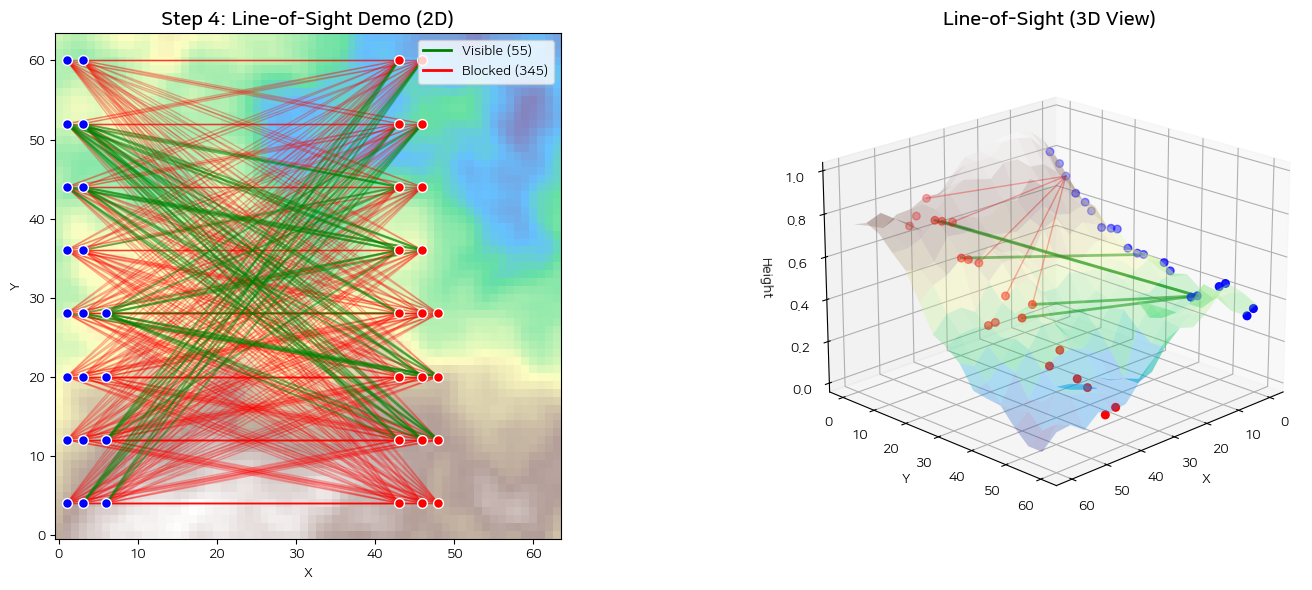

In [38]:
# 가시성 분석기 초기화
visibility_analyzer = VisibilityAnalyzer(observer_height=OBSERVER_HEIGHT, epsilon=EPSILON)

# 데모용으로 몇 개의 시야선만 체크
num_demo_lines = 20
demo_observers = observer_points[:num_demo_lines]
demo_targets = target_points[:num_demo_lines]

print(f"{num_demo_lines}개 시야선 계산 중...")

visible_lines = []
blocked_lines = []

for obs in demo_observers:
    for tgt in demo_targets:
        obs_point = (int(obs[0]), int(obs[1]))
        tgt_point = (int(tgt[0]), int(tgt[1]))
        
        if visibility_analyzer.check_line_of_sight(obs_point, tgt_point, heightmap):
            visible_lines.append((obs, tgt))
        else:
            blocked_lines.append((obs, tgt))

print(f"✓ 가시: {len(visible_lines)}개, 차단: {len(blocked_lines)}개")

# 시각화
fig = plt.figure(figsize=(16, 6))

# 좌측: 2D 뷰
ax1 = fig.add_subplot(121)
ax1.imshow(heightmap, cmap='terrain', origin='lower', alpha=0.6)

# 차단된 선 (빨간색)
for obs, tgt in blocked_lines:
    ax1.plot([obs[0], tgt[0]], [obs[1], tgt[1]], 'r-', alpha=0.3, linewidth=1)

# 가시 선 (녹색)
for obs, tgt in visible_lines:
    ax1.plot([obs[0], tgt[0]], [obs[1], tgt[1]], 'g-', alpha=0.5, linewidth=1.5)

ax1.scatter(demo_observers[:, 0], demo_observers[:, 1], 
           c='blue', s=50, zorder=5, edgecolors='white', linewidth=1)
ax1.scatter(demo_targets[:, 0], demo_targets[:, 1], 
           c='red', s=50, zorder=5, edgecolors='white', linewidth=1)

# 범례
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='g', linewidth=2, label=f'Visible ({len(visible_lines)})'),
    Line2D([0], [0], color='r', linewidth=2, label=f'Blocked ({len(blocked_lines)})')
]
ax1.legend(handles=legend_elements, loc='upper right')

ax1.set_title('Step 4: Line-of-Sight Demo (2D)', fontsize=14, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# 우측: 3D 뷰
ax2 = fig.add_subplot(122, projection='3d')
x = np.arange(0, MAP_WIDTH, 4)
y = np.arange(0, MAP_HEIGHT, 4)
X, Y = np.meshgrid(x, y)
Z = heightmap[::4, ::4]
ax2.plot_surface(X, Y, Z, cmap='terrain', alpha=0.3, antialiased=True)

# 차단된 선
for obs, tgt in blocked_lines[:5]:  # 너무 많으면 복잡하므로 일부만
    ax2.plot([obs[0], tgt[0]], [obs[1], tgt[1]], [obs[2], tgt[2]], 
            'r-', alpha=0.4, linewidth=1)

# 가시 선
for obs, tgt in visible_lines[:5]:
    ax2.plot([obs[0], tgt[0]], [obs[1], tgt[1]], [obs[2], tgt[2]], 
            'g-', alpha=0.6, linewidth=2)

ax2.scatter(demo_observers[:, 0], demo_observers[:, 1], demo_observers[:, 2],
           c='blue', s=30, zorder=5)
ax2.scatter(demo_targets[:, 0], demo_targets[:, 1], demo_targets[:, 2],
           c='red', s=30, zorder=5)

ax2.set_title('Line-of-Sight (3D View)', fontsize=14, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Height')
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

visibility_rate = len(visible_lines) / (len(visible_lines) + len(blocked_lines))

---

# 5. 노출도(Exposure) 계산

각 팀의 **전술적 취약성**을 **픽셀 단위로** 정량화합니다.

## 전수 조사 (Exhaustive Analysis)

**모든 픽셀**에 대해 정확한 노출도를 계산합니다:
- Team A 존의 각 픽셀이 Team B에게 얼마나 보이는지
- Team B 존의 각 픽셀이 Team A에게 얼마나 보이는지

### 계산 방법
```
각 타겟 픽셀에 대해:
  visible_count = 0
  for each observer_pixel:
    if can_see(observer_pixel, target_pixel):
      visible_count += 1
  
  exposure = visible_count / total_observers
```

### Exposure Ratio 의미
- **0.0** = 전혀 안 보임 (완전 엄폐, 안전한 위치)
- **0.5** = 절반 보임 (중간 노출)
- **1.0** = 완전히 보임 (완전 노출, 위험한 위치)

### 수치 해석 (예시)
- 0.0~0.2: 낮은 노출 (방어적, 엄폐 지역)
- 0.2~0.4: 적당한 노출 (균형잡힌 지역)
- 0.4~0.6: 높은 노출 (공격적, 개방 지역)
- 0.6~1.0: 매우 높은 노출 (위험 지역)


In [39]:
import time

print("=" * 80)
print("픽셀별 전수 조사 시작")
print("=" * 80)

# 방법 1: create_full_analysis 사용 (권장)
if USE_FULL_ANALYSIS:
    print("🔬 모드: FULL (전수 조사 - 모든 픽셀 분석)")
    print(f"⏳ 예상 시간: {MAP_WIDTH}x{MAP_HEIGHT} 맵 = 약 2-5분")
    print()
    
    start_time = time.time()
    
    # 전수 조사 실행
    analysis_results = create_full_analysis(
        map_data,
        observer_height=OBSERVER_HEIGHT,
        use_full_analysis=True  # ← 전수 조사 모드
    )
    
    elapsed = time.time() - start_time
    print(f"분석 완료 (소요 시간: {elapsed:.1f}초 = {elapsed/60:.2f}분)")
    
else:
    print("모드: SAMPLING (샘플링 - 빠른 근사)")
    print(f"샘플 수: {NUM_SAMPLES}개/존")
    print()
    
    start_time = time.time()
    
    analysis_results = create_full_analysis(
        map_data,
        num_samples=NUM_SAMPLES,
        observer_height=OBSERVER_HEIGHT,
        use_full_analysis=False  # 샘플링 모드
    )
    
    elapsed = time.time() - start_time
    print(f"분석 완료! (소요 시간: {elapsed:.1f}초)")

print()


INFO     | Using FULL pixel-by-pixel analysis (exhaustive search)
INFO     | Starting FULL pixel-by-pixel visibility analysis
INFO     | Analyzing 2 zone pairs
INFO     | Calculating pixel-by-pixel exposure: team_a_zone -> team_b_zone
INFO     | Full analysis: 1,344 observers × 1,408 targets = 1,892,352 checks


픽셀별 전수 조사 시작
🔬 모드: FULL (전수 조사 - 모든 픽셀 분석)
⏳ 예상 시간: 64x64 맵 = 약 2-5분



INFO     | Pixel exposure map complete: mean=0.242
INFO     | Calculating pixel-by-pixel exposure: team_b_zone -> team_a_zone
INFO     | Full analysis: 1,408 observers × 1,344 targets = 1,892,352 checks
INFO     | Pixel exposure map complete: mean=0.242
INFO     | Full analysis complete: Team A=0.242, Team B=0.242, Diff=0.000


분석 완료 (소요 시간: 207.2초 = 3.45분)



노출도 분석 결과:
  Team A: 0.2418 (24.18%)
  Team B: 0.2421 (24.21%)
  평균: 0.2420
  차이: 0.0002

픽셀별 노출도 맵 생성됨
  Team A 맵 크기: (64, 64)
  Team B 맵 크기: (64, 64)

  Team A 노출도 범위: 0.000 ~ 0.801
  Team B 노출도 범위: 0.000 ~ 0.749

  Team A: 위험 지역 184px, 안전 지역 945px
  Team B: 위험 지역 261px, 안전 지역 902px



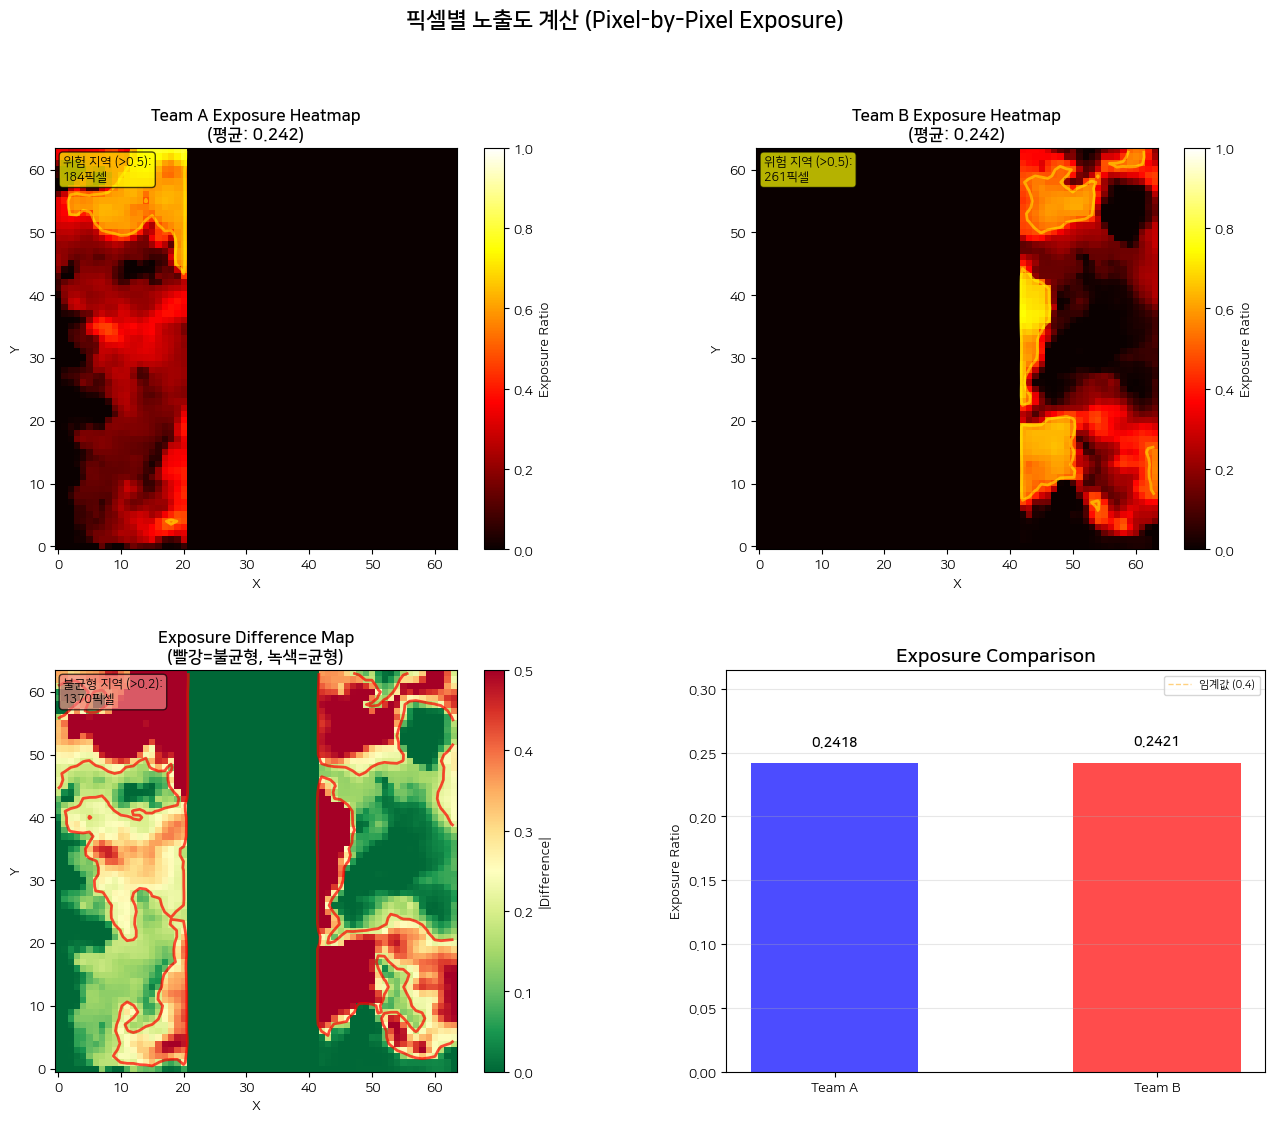


노출도 차이: 0.0002


In [108]:
# 결과 추출
metrics = analysis_results['visibility_metrics']
team_a_exposure = metrics['team_a_exposure']
team_b_exposure = metrics['team_b_exposure']
avg_exposure = metrics['avg_exposure']
exposure_diff = metrics['exposure_difference']

print("노출도 분석 결과:")
print(f"  Team A: {team_a_exposure:.4f} ({team_a_exposure*100:.2f}%)")
print(f"  Team B: {team_b_exposure:.4f} ({team_b_exposure*100:.2f}%)")
print(f"  평균: {avg_exposure:.4f}")
print(f"  차이: {exposure_diff:.4f}")
print()

# 픽셀별 노출도 맵 가져오기
team_a_exposure_map = analysis_results.get('team_a_exposure_map')
team_b_exposure_map = analysis_results.get('team_b_exposure_map')

if team_a_exposure_map is not None:
    print("픽셀별 노출도 맵 생성됨")
    print(f"  Team A 맵 크기: {team_a_exposure_map.shape}")
    print(f"  Team B 맵 크기: {team_b_exposure_map.shape}")
    
    # 픽셀별 통계
    team_a_mask = map_data.get_zone_mask('team_a_zone')
    team_b_mask = map_data.get_zone_mask('team_b_zone')
    
    a_values = team_a_exposure_map[team_a_mask]
    b_values = team_b_exposure_map[team_b_mask]
    
    print(f"\n  Team A 노출도 범위: {a_values.min():.3f} ~ {a_values.max():.3f}")
    print(f"  Team B 노출도 범위: {b_values.min():.3f} ~ {b_values.max():.3f}")
    
    # 위험/안전 지역 통계
    a_high_exposure = np.sum(a_values > 0.5)
    a_safe = np.sum(a_values < 0.3)
    b_high_exposure = np.sum(b_values > 0.5)
    b_safe = np.sum(b_values < 0.3)
    
    print(f"\n  Team A: 위험 지역 {a_high_exposure}px, 안전 지역 {a_safe}px")
    print(f"  Team B: 위험 지역 {b_high_exposure}px, 안전 지역 {b_safe}px")
else:
    print("샘플링 모드: 픽셀별 맵 없음 (균일한 노출도 사용)")
    # 샘플링 모드용 폴백
    team_a_exposure_map = np.zeros((MAP_HEIGHT, MAP_WIDTH))
    team_b_exposure_map = np.zeros((MAP_HEIGHT, MAP_WIDTH))
    team_a_mask = map_data.get_zone_mask('team_a_zone')
    team_b_mask = map_data.get_zone_mask('team_b_zone')
    team_a_exposure_map[team_a_mask] = team_a_exposure
    team_b_exposure_map[team_b_mask] = team_b_exposure

print("=" * 80)
print()

# 시각화
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Team A 노출도 히트맵
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(team_a_exposure_map, cmap='hot', origin='lower', vmin=0, vmax=1)
ax1.set_title(f'Team A Exposure Heatmap\n(평균: {team_a_exposure:.3f})', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
cbar1 = plt.colorbar(im1, ax=ax1, label='Exposure Ratio')

# 위험 지역 표시
if team_a_exposure_map is not None and USE_FULL_ANALYSIS:
    high_exp = team_a_exposure_map > 0.5
    ax1.contour(team_a_exposure_map, levels=[0.5], colors='yellow', 
                linewidths=2, alpha=0.5)
    ax1.text(0.02, 0.98, f'위험 지역 (>0.5):\n{a_high_exposure}픽셀', 
            transform=ax1.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            fontsize=9)

# 2. Team B 노출도 히트맵
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(team_b_exposure_map, cmap='hot', origin='lower', vmin=0, vmax=1)
ax2.set_title(f'Team B Exposure Heatmap\n(평균: {team_b_exposure:.3f})', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
cbar2 = plt.colorbar(im2, ax=ax2, label='Exposure Ratio')

# 위험 지역 표시
if team_b_exposure_map is not None and USE_FULL_ANALYSIS:
    ax2.contour(team_b_exposure_map, levels=[0.5], colors='yellow', 
                linewidths=2, alpha=0.5)
    ax2.text(0.02, 0.98, f'위험 지역 (>0.5):\n{b_high_exposure}픽셀', 
            transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
            fontsize=9)

# 3. 노출도 차이 맵
ax3 = fig.add_subplot(gs[1, 0])
diff_map = np.abs(team_a_exposure_map - team_b_exposure_map)
im3 = ax3.imshow(diff_map, cmap='RdYlGn_r', origin='lower', vmin=0, vmax=0.5)
ax3.set_title('Exposure Difference Map\n(빨강=불균형, 녹색=균형)', 
              fontsize=12, fontweight='bold')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
cbar3 = plt.colorbar(im3, ax=ax3, label='|Difference|')

# 불균형 지역 하이라이트
if USE_FULL_ANALYSIS:
    imbalanced = diff_map > 0.2
    imbalanced_count = np.sum(imbalanced)
    ax3.contour(diff_map, levels=[0.2], colors='red', linewidths=2, alpha=0.7)
    ax3.text(0.02, 0.98, f'불균형 지역 (>0.2):\n{imbalanced_count}픽셀', 
            transform=ax3.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
            fontsize=9)

# 4. 비교 차트와 통계
ax4 = fig.add_subplot(gs[1, 1])

# 바 차트 (inset)
x_pos = [0, 0.5]
exposures = [team_a_exposure, team_b_exposure]
colors = ['blue', 'red']
bars = ax4.bar(x_pos, exposures, color=colors, alpha=0.7, width=0.26)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(['Team A', 'Team B'])
ax4.set_ylabel('Exposure Ratio')
ax4.set_ylim(0, max(exposures) * 1.3)
ax4.set_title('Exposure Comparison', fontsize=14, fontweight='bold')
ax4.axhline(y=0.4, color='orange', linestyle='--', linewidth=1, 
                  alpha=0.5, label='임계값 (0.4)')
ax4.legend(fontsize=8)
ax4.grid(axis='y', alpha=0.3)

# 값 표시
for i, (bar, exp) in enumerate(zip(bars, exposures)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{exp:.4f}',
                  ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('픽셀별 노출도 계산 (Pixel-by-Pixel Exposure)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# 밸런스 평가
print(f"\n노출도 차이: {exposure_diff:.4f}")

---

# 6. 밸런스 검증


사전 정의된 **검증 규칙**을 적용하여 맵의 공정성을 판단합니다.

### 기본 검증 규칙 5가지 예시. validation_engine.py에서 변경

1. **Maximum Exposure**: `max_team_exposure < 0.4`
   - 어느 팀도 과도하게 노출되지 않음

2. **Exposure Balance**: `|team_a - team_b| < 0.15`
   - 두 팀의 노출도 차이가 작음

3. **Minimum Average Exposure**: `avg_exposure > 0.1`
   - 교전이 일어날 정도의 노출

4. **Zone Coverage**: `coverage > 0.8`
   - 대표성 있는 샘플링

5. **Terrain Variation**: `std > 0.05`
   - 지형에 변화가 있음


In [95]:
# 검증 엔진 설정
engine = ValidationEngine()
for rule in create_default_rules():
    engine.add_rule(rule)

print(f"{len(engine.rules)}개 검증 규칙 적용 중...")

# 검증 수행
validation_result = engine.validate(analysis_results)
summary = validation_result.get_summary()

print("검증 완료")
print(f"\n검증 결과: {'PASSED' if summary['overall_passed'] else '✗ FAILED'}")
print(f"   통과율: {summary['passed_rules']}/{summary['total_rules']} ({summary['passed_rules']/summary['total_rules']*100:.0f}%)")

results_text = "Validation Rules\n" + "="*50 + "\n\n"
for rule_id, rule_data in validation_result.rule_results.items():
    passed, actual_value, message = rule_data
    
    status = "" if passed else "✗"
    results_text += f"{status} {rule_id}\n"
    results_text += f"  Value: {actual_value:.4f}\n"
    if message:
        results_text += f"  {message}\n"
    results_text += "\n"


print(results_text)

print(f"""
{'='*80}
                           FINAL VALIDATION REPORT
{'='*80}

Overall Status: {'PASSED - Map is balanced and ready to use!' if summary['overall_passed'] else '✗ FAILED - Map needs regeneration'}

Pass Rate: {summary['passed_rules']}/{summary['total_rules']} rules ({summary['passed_rules']/summary['total_rules']*100:.0f}%)

Key Metrics:
 - Team A Exposure: {team_a_exposure:.3f} ({team_a_exposure*100:.1f}%)
 - Team B Exposure: {team_b_exposure:.3f} ({team_b_exposure*100:.1f}%)
 - Average Exposure: {avg_exposure:.3f}
 - Exposure Difference: {exposure_diff:.3f} {'Good' if exposure_diff < 0.15 else '⚠ Too High'}
 - Terrain Variation: {stats['std']:.3f} {'Good' if stats['std'] > 0.05 else '⚠ Too Flat'}

Map Parameters:
 - Dimensions: {MAP_WIDTH}x{MAP_HEIGHT}
 - Seed: {SEED}
 - Samples: {NUM_SAMPLES} per zone
 - Observer Height: {OBSERVER_HEIGHT}

{'='*80}
""")

ax3.text(0.05, 0.95, metrics_summary, fontsize=11, family='monospace',
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat' if summary['overall_passed'] else 'lightcoral', alpha=0.3))

plt.suptitle('Step 6: Validation Results', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# 최종 결론
print("\n" + "="*80)
if summary['overall_passed']:
    print("맵이 모든 검증 규칙을 통과했습니다")
    print("   이 맵은 균형잡혀 있으며 게임에 사용할 수 있습니다.")
else:
    print("맵이 일부 검증 규칙을 통과하지 못했습니다.")
    print("   파라미터를 조정하거나 다른 시드로 재생성하는 것을 권장합니다.")
    print(f"\n   실패한 규칙: {summary['failed_rules']}개")
    for rule_result in validation_result.rule_results:
        if not rule_result.passed:
            print(f"   • {rule_result.rule_id}: {rule_result.message}")
print("="*80)

INFO     | Starting validation with 5 rules
INFO     | Validation complete: PASSED (5/5 rules passed)


5개 검증 규칙 적용 중...
검증 완료

검증 결과: PASSED
   통과율: 5/5 (100%)
Validation Rules

 max_exposure_limit
  Value: 0.2421
  ✓ Maximum sight exposure must be below 40%: 0.2421

 exposure_balance
  Value: 0.0002
  ✓ Exposure difference between teams must be below 15%: 0.0002

 minimum_exposure
  Value: 0.2420
  ✓ Average exposure must exceed 10% to avoid stalemate: 0.2420

 team_a_exposure_range
  Value: 0.2418
  ✓ Team A exposure must be between 10% and 50%: 0.2418

 team_b_exposure_range
  Value: 0.2421
  ✓ Team B exposure must be between 10% and 50%: 0.2421



                           FINAL VALIDATION REPORT

Overall Status: PASSED - Map is balanced and ready to use!

Pass Rate: 5/5 rules (100%)

Key Metrics:
 - Team A Exposure: 0.242 (24.2%)
 - Team B Exposure: 0.242 (24.2%)
 - Average Exposure: 0.242
 - Exposure Difference: 0.000 Good
 - Terrain Variation: 0.231 Good

Map Parameters:
 - Dimensions: 64x64
 - Seed: 4
 - Samples: 50 per zone
 - Observer Height: 0.05




<Figure size 1200x800 with 0 Axes>


맵이 모든 검증 규칙을 통과했습니다
   이 맵은 균형잡혀 있으며 게임에 사용할 수 있습니다.


---

## 다음 실험 아이디어

### 파라미터 조정 실험
맨 위의 "파라미터 설정" 셀로 돌아가서 다음 값들을 변경:

```python
# 더 험준한 지형을 원한다면
OCTAVES = 8              # 6 → 8
PERSISTENCE = 0.6        # 0.5 → 0.6

# 더 평탄한 지형을 원한다면
OCTAVES = 4              # 6 → 4
PERSISTENCE = 0.4        # 0.5 → 0.4

# 더 정확한 분석을 원한다면
NUM_SAMPLES = 100        # 50 → 100

# 다른 맵을 생성하려면
SEED = 123               # 아무 숫자로 변경
```

### 추가 분석

- 여러 시드로 맵을 생성하여 검증 통과율 비교
- 파라미터와 노출도의 상관관계 분석
- 최적의 파라미터 조합 찾기

### 시스템 활용

```bash
# Python 스크립트로 자동 생성
python examples/generate_maps.py

# 여러 맵 비교
python examples/visualize_steps.py --multiple

# 로깅과 함께 실행
python examples/test_with_logging.py
```

---

## 📚 참고 자료

- **VISUALIZATION_GUIDE.md**: 각 단계 상세 설명
- **README.md**: 시스템 전체 가이드
- **claude.md**: 프로젝트 설계 문서

---